# CNN on MNIST

In this notebook, we train one of oldest CNNs, called [_LeNet_](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf), to classify hand-written digits from 0 to 9 in MNIST dataset. If you are not familiar with [_MNIST_](http://yann.lecun.com/exdb/mnist/), try the previously covered [MNIST MLP](https://github.com/drinkingkazu/ExampleNotebooks/blob/master/MNIST%20MLP.ipynb) notebook. LeNet is one of the very first CNN application and nearly 2 decades old.

This notebook is very similar to [MNIST MLP](https://github.com/drinkingkazu/ExampleNotebooks/blob/master/MNIST%20MLP.ipynb) notebook and we will use the same functions introduced before. Those are put in `mnist_classification` python module to keep the notebook concise.

In [1]:
from __future__ import print_function
import torch
import numpy as np

## Create DataLoader

In [2]:
from torchvision import datasets, transforms
LOCAL_DATA_DIR = './data' # this is where data files are downloaded

# Train data loader
train_data = datasets.MNIST(LOCAL_DATA_DIR, train=True, download=True,
                            transform=transforms.Compose([transforms.ToTensor()]))
train_loader = torch.utils.data.DataLoader(train_data,batch_size=20,shuffle=True,num_workers=2,pin_memory=True)

# Test data loader
test_data = datasets.MNIST(LOCAL_DATA_DIR, train=True, download=False,
                           transform=transforms.Compose([transforms.ToTensor()]))
test_loader = torch.utils.data.DataLoader(test_data,batch_size=20,shuffle=False,num_workers=2,pin_memory=True)

## Define LeNet
LeNet has 2 convolution layers, each followed by rectified linear unit (ReLU) and max-pooling, for feature extractions. Then the extracted features run through two hidden layers multi-layer perceptron (MLP) at the end for classifying the input image data into digits (0 to 9).

In [3]:
class LeNet(torch.nn.Module):
    def __init__(self):
        
        super(LeNet, self).__init__()
        # feature extractor CNN
        self._feature_extractor = torch.nn.Sequential(
            torch.nn.Conv2d(1,6,5),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2,2),
            torch.nn.Conv2d(6,16,5),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2,2) )
        # classifier MLP
        self._classifier = torch.nn.Sequential(
            torch.nn.Linear(256,120),
            torch.nn.ReLU(),
            torch.nn.Linear(120,84),
            torch.nn.ReLU(),
            torch.nn.Linear(84,10) )

    def forward(self, x):
        # extract features
        features = self._feature_extractor(x)
        # flatten the 3d tensor (2d space x channels = features)
        features = features.view(-1, np.prod(features.size()[1:]))
        # classify and return
        return self._classifier(features)

## Train
Like last time, we define a _BLOB_ container. Our loss function (`nn.CrossEntropyLoss`), and Adam optimizer algorithm. 

In [4]:
class BLOB:
    pass
blob=BLOB()
blob.net       = LeNet().cuda() # construct Lenet, use GPU
blob.criterion = torch.nn.CrossEntropyLoss() # use softmax loss to define an error
blob.optimizer = torch.optim.Adam(blob.net.parameters()) # use Adam optimizer algorithm
blob.softmax   = torch.nn.Softmax(dim=1) # not for training, but softmax score for each class
blob.iteration = 0    # integer count for the number of train steps
blob.data      = None # data for training/analysis
blob.label     = None # label for training/analysis

Now import the `train_loop` function which takes _blob_ and DataLoader. By default it runs 2000 iterations of training (configurable, 3rd argument).

In [5]:
from mnist_classification import train_loop
train_loop(blob,train_loader)

Iteration 0 ... Loss 2.29998707771 ... Accuracy 0.05
Iteration 99 ... Loss 0.56286406517 ... Accuracy 0.9
Iteration 199 ... Loss 0.612768769264 ... Accuracy 0.75
Iteration 299 ... Loss 0.402241140604 ... Accuracy 0.95
Iteration 399 ... Loss 0.269223213196 ... Accuracy 0.95
Iteration 499 ... Loss 0.0533517971635 ... Accuracy 1.0
Iteration 599 ... Loss 0.157213658094 ... Accuracy 0.95
Iteration 699 ... Loss 0.379967868328 ... Accuracy 0.85
Iteration 799 ... Loss 0.0646946877241 ... Accuracy 1.0
Iteration 899 ... Loss 0.362897396088 ... Accuracy 0.9
Iteration 999 ... Loss 0.0546049959958 ... Accuracy 1.0
Iteration 1099 ... Loss 0.0707225874066 ... Accuracy 1.0
Iteration 1199 ... Loss 0.117708727717 ... Accuracy 0.95
Iteration 1299 ... Loss 0.236603304744 ... Accuracy 0.9
Iteration 1399 ... Loss 0.191362649202 ... Accuracy 0.9
Iteration 1499 ... Loss 0.0265464782715 ... Accuracy 1.0
Iteration 1599 ... Loss 0.166635081172 ... Accuracy 0.95
Iteration 1699 ... Loss 0.400308132172 ... Accuracy

## Evaluation
The evaluation loop is also put in `mnist_classification` module :) Just import `inference` function which takes a blob and DataLoader.

Train set accuracy mean 0.9717833333333334 std 0.037278050586847425


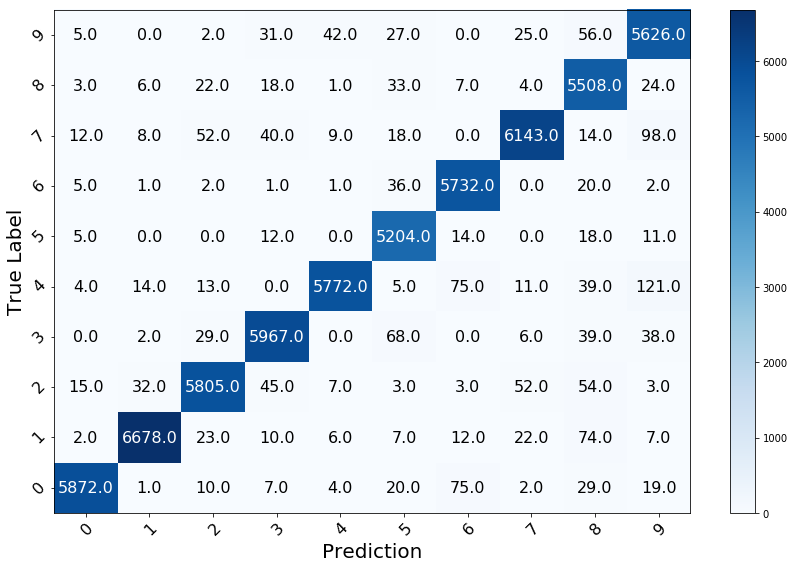

Test set accuracy mean 0.9717833333333334 std 0.037411937340313665


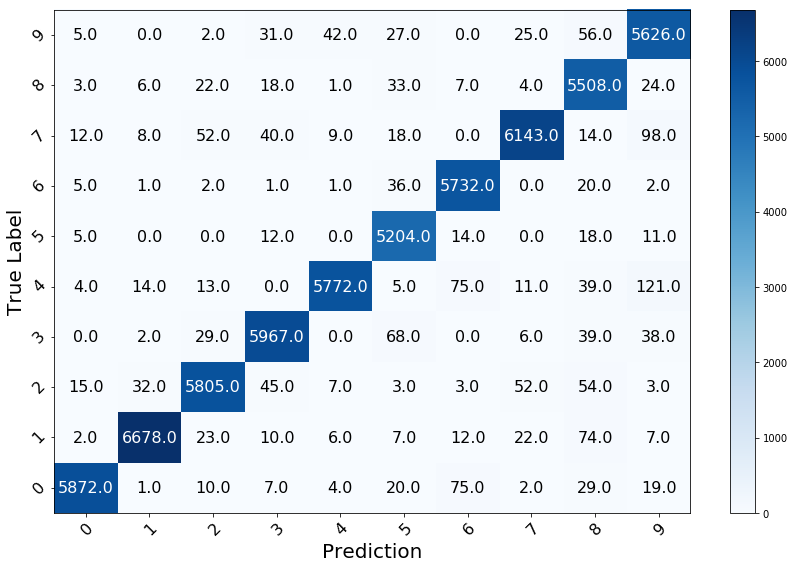

In [6]:
from mnist_classification import inference
# For plotting a confusion matrix
%matplotlib inline
from utils import plot_confusion_matrix

# For the Train set
accuracy, label, prediction = inference(blob,train_loader)
print("Train set accuracy mean",accuracy.mean(),"std",accuracy.std())
plot_confusion_matrix(label,prediction,[str(d) for d in range(10)])

# For the Test set
accuracy, label, prediction = inference(blob,test_loader)
print("Test set accuracy mean",accuracy.mean(),"std",accuracy.std())
plot_confusion_matrix(label,prediction,[str(d) for d in range(10)])

The accuracy seems slightly better than MLP example, maybe by 1.5%. 